# Predicting Myers-Briggs Personality Types from Twitter Posts

---

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis (EDA)

In [1]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string
import nltk

from string import punctuation

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from textblob import TextBlob

In [2]:
# Load dataset
df = pd.read_csv('mbti_clean.csv')

<a id='data-dictionary'></a>
**Data Dictionary** 

Variables in original dataframe:
- *type*: (string) four-letter Myers-Briggs Type Index (MBTI) code
- *posts*: (string) text of fifty most recent posts to the *PersonalityCafe* forum

New variables added for analysis in the *df* dataframe:
- *I-E*: (string) code on Introversion-Extroversion axis, derived from *type*
- *N-S*: (string) code on Intuition-Sensing axis, derived from *type*
- *T-F*: (string) code on Thinking-Feeling axis, derived from *type*
- *J-P*: (string) code on Judging-Perceiving axis, derived from *type*
- *posts_r*: (string) cleaned post text, derived from *posts*
- *total_words*: (integer) number of total words across 50 posts, derived from *posts*
- *avg_words_per_post*: (float) average number of words per post, derived from *posts* and *total words*
- *polarity*: (float) polarity score (range -1 to 1)
- *subjectivity*: (float) subjectivity score (range 0 to 1)

In [3]:
# View first five rows of dataset
df.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [4]:
# View shape of dataset
df.shape

(283792, 2)

In [5]:
# View information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283792 entries, 0 to 283791
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   type    283792 non-null  object
 1   posts   283792 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


The column names are 'type' and 'posts'. Both are datatype 'object'. There are no null values.

In [6]:
# Examine number of unique items are in the 'type' (classification) column
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

The 'type' column contains 16 unique codes, representing the 16 different personality types.

In [7]:
# Explore the counts for each of these types
df['type'].value_counts()

INFP    60583
INFJ    50417
INTP    42071
INTJ    35109
ENFP    22361
ENTP    21922
ISTP    10404
ISFP     8089
ENTJ     7597
ISTJ     6679
ENFJ     6481
ISFJ     5435
ESTP     2697
ESFJ     1441
ESFP     1256
ESTJ     1250
Name: type, dtype: int64

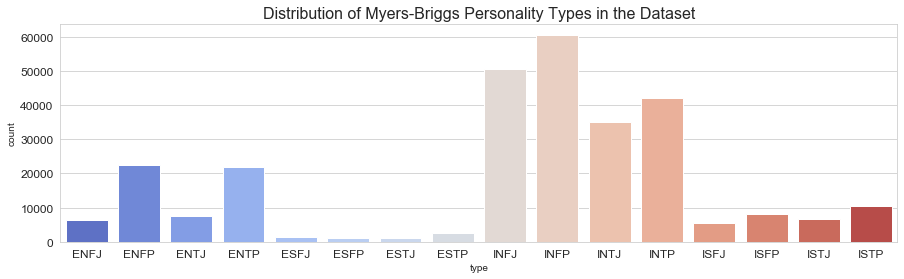

In [8]:
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Personality Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [9]:
# Explore the counts for each axis of the types
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    218787
E     65005
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    246541
S     37251
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    156063
T    127729
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    169383
J    114409
Name: type, dtype: int64 



The dataset contains many more Introverts (I) than Extroverts (E), and more Intuitives (N) than Sensers (S). The distributions of Thinkers (T) vs. Feelers (F), and Judgers (J) vs. Perceivers (P) are more balanced.

---

<a id='preprocessing'></a>
## Preprocessing

In [10]:
# Create a working copy of the dataframe
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [11]:
# Create a binary column for each of the 4 axis types for later analysis
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,The last thing INFJ friend posted his facebo...,Introversion,Intuition,Feeling,Judging
1,INFJ,Hello ENFJ Sorry hear your distress Its only...,Introversion,Intuition,Feeling,Judging
2,INFJ,Prozac wellbrutin least thirty minutes movin...,Introversion,Intuition,Feeling,Judging
3,INFJ,Basically come with three items youve determi...,Introversion,Intuition,Feeling,Judging
4,INFJ,All things moderation Sims indeed video ga...,Introversion,Intuition,Feeling,Judging


Codes for the new columns:
- I-E: Introversion - Extroversion
- N-S: Intuition - Sensing
- T-F: Thinking - Feeling
- J-P: Judging - Perceiving

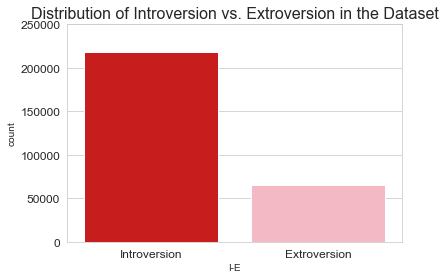

In [12]:
# Plot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above show that the dataset is heavily skewed toward Introversion over Extroversion.

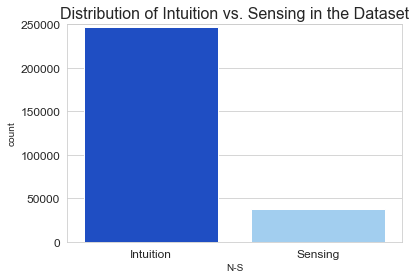

In [13]:
# Plot of Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is heavily skewed toward Intuition over Sensing.

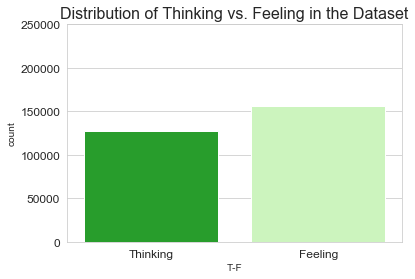

In [14]:
# Plot of Thinking - Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is somewhat skewed toward Feeling over Thinking.

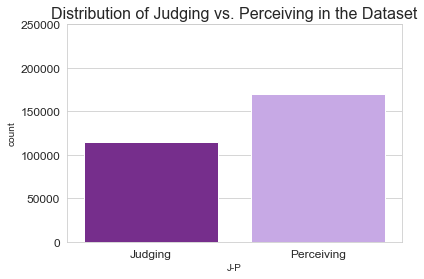

In [15]:
# Plot of Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is moderately skewed toward Perceiving over Judging.

In [16]:
# Subset the posts column for further exploration
posts = df['posts'].str.lower()

#### Word count

In [26]:
# Separate posts into individual words
# Then show the top 25

# Create the stopwords list
stoplist = stopwords.words('english') + list(punctuation)

# Add to the stopwords list each of the 16 codes
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']

for type in types:
    stoplist.append(type)

print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [39]:
# Create a word counter    
word_count = Counter(word_tokenize('\n'.join(posts)))

#words_top_25 = [word for word in word_count if not word in stoplist]

words_top_25 = []
freq_top_25 = []

print("\nMost frequent words with counts:")

## QUESTION: why the number is different????
for word, frequency in word_count.most_common(68):
    if word not in stoplist:
        print('%s: %d' % (word, frequency))
        words_top_25.append(word)
        freq_top_25.append(frequency)
print("\n")


Most frequent words with counts:
like: 60784
dont: 47647
think: 44665
people: 43085
know: 32985
really: 31821
one: 31603
would: 30973
get: 27596
ive: 27445
time: 24347
feel: 21142
much: 20473
well: 19531
things: 19089
say: 17957
something: 17696
way: 17685
good: 17443
want: 17245
see: 16926
love: 16820
also: 16617
even: 15406
always: 15177




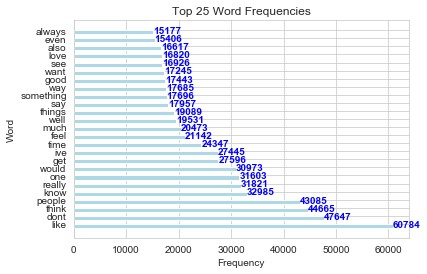

In [48]:
# Plot the counts of the 25 most frequent words
# Horizontal Boxplots
fig, ax = plt.subplots()
width = 0.5
ind = np.arange(len(words_top_25))
ax.barh(ind, freq_top_25, width, color = 'lightblue')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words_top_25, minor = False)
for i, v in enumerate(freq_top_25):
    ax.text(v + 2, i - 0.125, str(v), color = 'blue', fontweight = 'bold')
plt.title('Top 25 Word Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

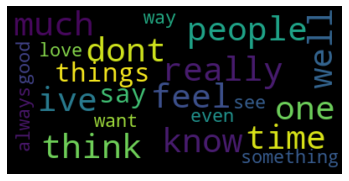

In [46]:
# Wordcloud Why not??
from wordcloud import WordCloud
from os import path

wordcloud_words = " ".join(words_top_25)
# Lower max font size
wordcloud = WordCloud(max_font_size = 40).generate(wordcloud_words)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

---

<a id='classification'></a>
## Classification

<a id='multiclass-classification'></a>
### Multiclass classification (16 classes)

##### Baseline calculation

A baseline is a fixed point of reference that is used for comparison purposes.

Predicting "INFP" *(most frequent type)* every time.

The accuracy will be the number of entries of "INFP" divided by the total number of entries of all personality types.

In [65]:
# Determine baseline
print("The count for the most frequent type (INFP) is: ")
print(df['type'].value_counts().max())

print("The total count of personality type entries is: ")
print(df['type'].value_counts().sum())

baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
print("The baseline is: ")
print(baseline)

The count for the most frequent type (INFP) is: 
60583
The total count of personality type entries is: 
283792
The baseline is: 
0.21347677172013305


##### Train-test split

In [66]:
# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(df['posts'].values,
                                                   df['type'].values,
                                                   test_size=0.30, random_state=42)
print("X_train: ")
print(len(X_train))
print("X_test: ") 
print(len(X_test))
print("y_train: ")
print(len(y_train))
print("y_test: ")
print(len(y_test))

X_train: 
198654
X_test: 
85138
y_train: 
198654
y_test: 
85138


##### Truncated SVD

*TruncatedSVD* is a variant of principal component analysis (pca) used on sparse matrices to reduce dimensionality

In [70]:
# Run CountVectorizer on the X train/test ('posts' column) using the arguments identified earlier
cv = CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

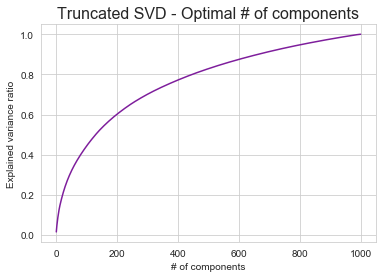

In [72]:
# Run Truncated SVD
# First use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

The graph above suggests that approximately 200 components would be most effective, since it is where the explained variance begins to flatten out.

In [73]:
# Run a Truncated SVD with 200 components
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(X_train_cv)
X_train_tsvd = tsvd.transform(X_train_cv)

X_test_cv = cv.transform(X_test)
X_test_tsvd = tsvd.transform(X_test_cv)

**Preprocessing Pipeline**

In [75]:
# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
    CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_train_tsvd = pipeline_preprocessing.fit_transform(X_train)
X_test_tsvd = pipeline_preprocessing.transform(X_test)

<a id='modeling'></a>
### Modeling

<a id='random-forest-classifier'></a>
#### Model: Random Forest Classifier

*RandomForestClassifier* is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [76]:
# Fit and score a Random Forest Classifier
# Parameters: 30 estimators, min 50 samples per leaf node, out-of-bag samples to estimate generalization accuracy
rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
rfc.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", rfc.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, rfc.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", rfc.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, rfc.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  0.3805913799873146
Confusion Matrix:
[[    0     0     0     0     0     0     0     0   866  3370    28   249
      0     0     0     0]
 [    0     9     0     0     0     0     0     0  2830 11675   166   932
      0     0     0     0]
 [    0     0     0     0     0     0     0     0  1063  3744    82   485
      0     0     0     0]
 [    0     0     0     5     0     0     0     0  2823 10992   195  1330
      0     0     0     0]
 [    0     0     0     0     0     0     0     0   185   737     8    63
      0     0     0     0]
 [    0     0     0     0     0     0     0     0   186   645     8    43
      0     0     0     0]
 [    0     0     0     0     0     0     0     0   146   612     9    73
      0     0     0     0]
 [    0     0     0     0     0     0     0     0   354  1373    20   149
      0     0     0     0]
 [    0     0     0     0     0     0     0     0 21379 13000   143   821
      0     0     0     0]
 [    0     0     0     0     

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00      4513
        ENFP       1.00      0.00      0.00     15612
        ENTJ       0.00      0.00      0.00      5374
        ENTP       1.00      0.00      0.00     15345
        ESFJ       0.00      0.00      0.00       993
        ESFP       0.00      0.00      0.00       882
        ESTJ       0.00      0.00      0.00       840
        ESTP       0.00      0.00      0.00      1896
        INFJ       0.51      0.60      0.55     35343
        INFP       0.30      0.97      0.46     42298
        INTJ       0.72      0.12      0.21     24522
        INTP       0.57      0.35      0.43     29440
        ISFJ       0.00      0.00      0.00      3842
        ISFP       1.00      0.00      0.00      5661
        ISTJ       0.00      0.00      0.00      4734
        ISTP       0.00      0.00      0.00      7359

    accuracy                           0.38    198654
   macro avg       0.32   

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00      1968
        ENFP       1.00      0.00      0.00      6749
        ENTJ       0.00      0.00      0.00      2223
        ENTP       1.00      0.00      0.00      6577
        ESFJ       0.00      0.00      0.00       448
        ESFP       0.00      0.00      0.00       374
        ESTJ       0.00      0.00      0.00       410
        ESTP       0.00      0.00      0.00       801
        INFJ       0.20      0.20      0.20     15074
        INFP       0.23      0.78      0.35     18285
        INTJ       0.31      0.03      0.06     10587
        INTP       0.19      0.09      0.12     12631
        ISFJ       0.00      0.00      0.00      1593
        ISFP       1.00      0.00      0.00      2428
        ISTJ       0.00      0.00      0.00      1945
        ISTP       0.00      0.00      0.00      3045

    accuracy                           0.22     85138
   macro avg       0.25   

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_rfc = np.array(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))

cm_randomforest = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])

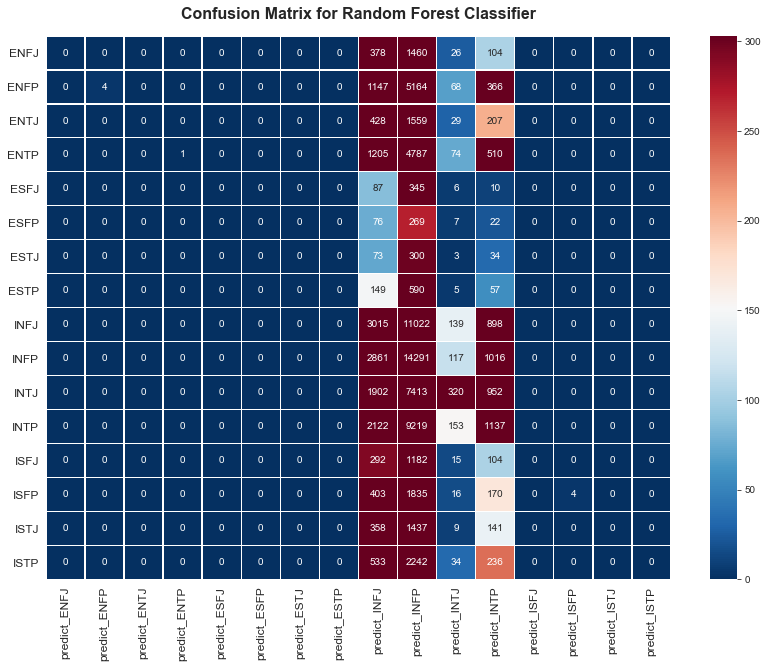

In [79]:
# Create confusion matrix heatmap of Random Forest Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm_randomforest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In the heatmapped confusion matrix above, it is clear that the Random Forest Classifier model is making predictions only within four of the sixteen classes:
INFJ, INFP, INTJ, and INTP, which are the most abundant classes in the dataset. The other twelve categories receive 
no predictions from this model at all. Despite having an accuracy score higher than the baseline, this model is not suited to predicting classes outside of the ones with the highest frequency.

<a id='k-neighbors-classifier'></a>
#### Model: KNeighborsClassifier

<a id='one-vs-rest-classifier'></a>
#### Model: OneVsRestClassifier



#### Model: Neural Network

#### Model: Naive Bayes Model

<a id='binary-classification'></a>
### Binary classification (each of the 4 axes)

##### Baseline calculation

In [ ]:
# Determine baseline for each of the four axes
baseline_IE = df_working['I-E'].value_counts().max() / df_working['I-E'].value_counts().sum()
baseline_NS = df_working['N-S'].value_counts().max() / df_working['N-S'].value_counts().sum()
baseline_TF = df_working['T-F'].value_counts().max() / df_working['T-F'].value_counts().sum()
baseline_JP = df_working['J-P'].value_counts().max() / df_working['J-P'].value_counts().sum()

print('Introversion - Extroversion: ', baseline_IE)
print('Intuition - Sensing: ', baseline_NS)
print('Thinking - Feeling: ', baseline_TF)
print('Judging - Perceiving: ', baseline_JP)